# From https://github.com/openvinotoolkit/openvino_notebooks


# Modifying notebook file from 228-clip-zero-shot-image-classification

## Zero-shot Image Classification with OpenAI CLIP and OpenVINO™

Zero-shot image classification is a computer vision task to classify images into one of several classes without any prior training or knowledge of the classes.

![zero-shot-pipeline](https://user-images.githubusercontent.com/29454499/207773481-d77cacf8-6cdc-4765-a31b-a1669476d620.png)

[**image source*](https://huggingface.co/tasks/zero-shot-image-classification)


Zero-shot learning resolves several challenges in image retrieval systems. For example, with the rapid growth of categories on the web, it is challenging to index images based on unseen categories. We can associate unseen categories to images with zero-shot learning by exploiting attributes to model's relationship between visual features and labels.
In this tutorial, we will use the [OpenAI CLIP](https://github.com/openai/CLIP) model to perform zero-shot image classification. The notebook contains the following steps:

1. Download the model.
2. Instantiate the PyTorch model.
3. Convert model to OpenVINO IR, using model conversion API.
4. Run CLIP with OpenVINO.

#### Table of content:
- [Instantiate model](#Instantiate-model-Uparrow)
- [Run PyTorch model inference](#Run-PyTorch-model-inference-Uparrow)

## Instantiate model [$\Uparrow$](#Table-of-content:)

CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on various (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task.
CLIP uses a [ViT](https://arxiv.org/abs/2010.11929) like transformer to get visual features and a causal language model to get the text features. The text and visual features are then projected into a latent space with identical dimensions. The dot product between the projected image and text features is then used as a similarity score.

![clip](https://raw.githubusercontent.com/openai/CLIP/main/CLIP.png)

[**image_source*](https://github.com/openai/CLIP/blob/main/README.md)

You can find more information about this model in the [research paper](https://arxiv.org/abs/2103.00020), [OpenAI blog](https://openai.com/blog/clip/), [model card](https://github.com/openai/CLIP/blob/main/model-card.md) and GitHub [repository](https://github.com/openai/CLIP).

In this notebook, we will use [openai/clip-vit-base-patch16](https://huggingface.co/openai/clip-vit-base-patch16), available via Hugging Face Transformers, but the same steps are applicable for other CLIP family models.

First, we need to create `CLIPModel` class object and initialize it with model configuration and weights, using `from_pretrained` method. The model will be automatically downloaded from Hugging Face Hub and cached for the next usage.
`CLIPProcessor` class is a wrapper for input data preprocessing. It includes both encoding the text using tokenizer and preparing the images.

In [2]:
%pip install -q gradio "openvino>=2023.1.0" "transformers[torch]>=4.30"

Note: you may need to restart the kernel to use updated packages.


In [1]:
from transformers import CLIPProcessor, CLIPModel

# load pre-trained model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
# load preprocessor for model input
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

2023-10-27 22:45:35.634408: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 22:45:35.880257: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 22:45:35.881587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 22:45:37.499800: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Run PyTorch model inference [$\Uparrow$](#Table-of-content:)

To perform classification, define labels and load an image in RGB format. To give the model for appropriate Instagram hastags, we extend the labels description using the template "The instagram hashtag of this photo is" instead of "This is a photo of a".
Both the list of label descriptions and image should be passed through the processor to obtain a dictionary with input data in the model-specific format. The model predicts an image-text similarity score in raw logits format, which can be normalized to the `[0, 1]` range using the `softmax` function. Then, we select labels with the highest similarity score for the final result.

In [2]:
f = open('hashtag.txt','r')
hashtags = []
for line in f.readlines():
    for t in range(len(line)):
        if line[t] == ' ':
            hashtags.append(line[1:t])
            break
        if line[t] == '\\' or line[t] == '\n':
            hashtags.append(line[1:t])
            break
print(hashtags)
print(len(hashtags))

['love', 'instagood', 'fashion', 'instagram', 'photooftheday', 'art', 'photography', 'beautiful', 'nature', 'picoftheday', 'travel', 'happy', 'cute', 'instadaily', 'style', 'tbt', 'repost', 'followme', 'summer', 'reels', 'like4like', 'beauty', 'fitness', 'food', 'instalike', 'explore', 'photo', 'me', 'selfie', 'music', 'viral', 'friends', 'life', 'fun', 'smile', 'family', 'ootd', 'girl', 'makeup', 'likeforlikes', 'dog', 'model', 'design', 'motivation', 'handmade', 'lifestyle', 'likeforlike', 'sunset', 'artist', 'dogsofinstagram', 'foodporn', 'followforfollowback', 'beach', 'drawing', 'amazing', 'nofilter', 'cat', 'instamood', 'igers', '일상', 'sun', 'flowers', 'sky', 'gym', 'wedding', 'moda', 'photographer', 'follow4follow', 'hair', 'foodie', 'inspiration', 'funny', 'instafood', 'memes', 'baby', 'naturephotography', 'l4l', 'nails', 'f4f', 'likeforfollow', 'workout', 'followforfollow', 'illustration', 'home', 'instapic', 'yummy', 'vsco', 'bestoftheday', 'landscape', 'catsofinstagram', 'vs

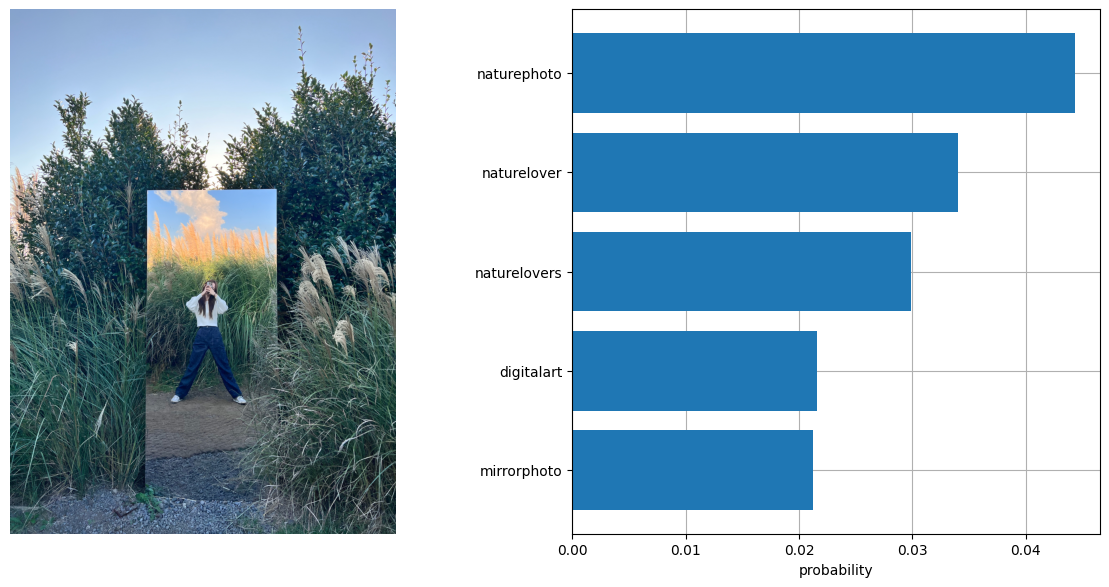

In [3]:
from urllib.request import urlretrieve
from pathlib import Path

from PIL import Image

urlretrieve(
    "https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/228-clip-zero-shot-image-classification/visualize.py",
    filename='visualize.py'
)
from visualize import visualize_result

image = Image.open('data/test2.jpg') # image path

input_labels = hashtags
text_descriptions = [f"The instagram hashtag of this photo is {label}" for label in input_labels]

inputs = processor(text=text_descriptions, images=[image], return_tensors="pt", padding=True)

results = model(**inputs)
logits_per_image = results['logits_per_image']  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1).detach().numpy()  # we can take the softmax to get the label probabilities
visualize_result(image, input_labels, probs[0])